In [ ]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import optimizers 
from keras import regularizers
import tensorflow as tf
from keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from keras.utils import np_utils
from keras.utils import to_categorical
import keras.utils
from numpy import argmax
import seaborn as sn 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras import regularizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = np.load('/content/drive/My Drive/Machine Leaning/repbase_LTRs_I_3dom.fasta.lineages_final.clean.npy')
Y = np.load('/content/drive/My Drive/Machine Leaning/repbase_LTRs_I_3dom.fasta.lineages_final.clean_lables.npy')

In [ ]:
print(X.shape)
print(Y.shape)

(2842, 5, 22576)
(2842, 1)


In [ ]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

(2273, 5, 22576)
(2273, 1)
(284, 5, 22576)
(284, 1)
(285, 5, 22576)
(285, 1)


In [ ]:
X = None
Y = None
path_log_base = './logs_CNN'

In [ ]:
def metrics(Y_validation,predictions):
    
    classes = len(numpy.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [ ]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [ ]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [ ]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [ ]:
def TERL():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(64, (5, 20), strides=(1,1), activation="relu", use_bias=True)(inputs)
    layers = tf.keras.layers.AveragePooling2D((1, 10), strides= (1, 10))(layers)
    # layer 2
    layers = tf.keras.layers.Conv2D(32, (1, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 3
    layers = tf.keras.layers.Conv2D(32, (1, 35), strides=(1,1), activation="relu", use_bias=True)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(1000,activation="relu")(layers)
    #layers = tf.keras.layers.Dense(1000,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Dense(500,activation="relu")(layers)
    #layers = tf.keras.layers.Dropout(0.05)(layers)
    #layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22576, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 22557, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 2255, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2236, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 149, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 115, 32)        35872     
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 7, 32)         

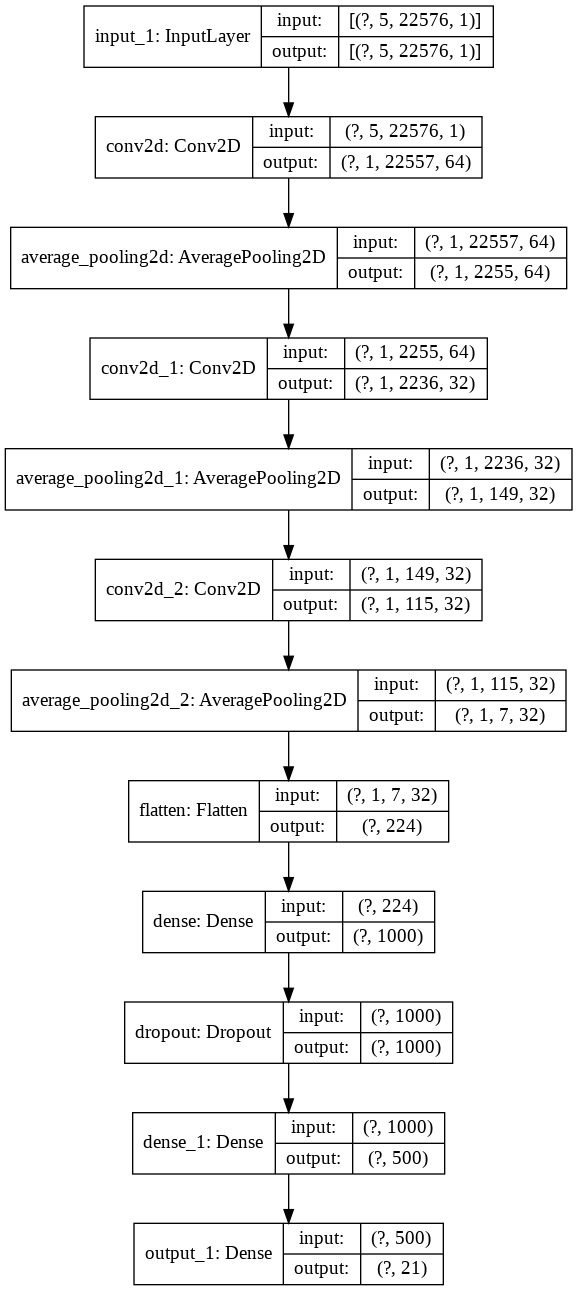

In [ ]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
one_hot_labels_train = keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, 32, epochs, "TERL")
Final_Results_Test(log_Dir) 

Epoch 1/100
72/72 [==============================] - 3s 44ms/step - loss: 1.6010 - accuracy: 0.3907 - val_loss: 1.3742 - val_accuracy: 0.4577
Epoch 2/100
72/72 [==============================] - 2s 25ms/step - loss: 1.2757 - accuracy: 0.4593 - val_loss: 1.2787 - val_accuracy: 0.5035
Epoch 3/100
72/72 [==============================] - 2s 25ms/step - loss: 1.0788 - accuracy: 0.5816 - val_loss: 1.2305 - val_accuracy: 0.5035
Epoch 4/100
72/72 [==============================] - 2s 25ms/step - loss: 0.9104 - accuracy: 0.6705 - val_loss: 0.8302 - val_accuracy: 0.7183
Epoch 5/100
72/72 [==============================] - 2s 25ms/step - loss: 0.7119 - accuracy: 0.7541 - val_loss: 0.8238 - val_accuracy: 0.7324
Epoch 6/100
72/72 [==============================] - 2s 25ms/step - loss: 0.6067 - accuracy: 0.7919 - val_loss: 0.7186 - val_accuracy: 0.7606
Epoch 7/100
72/72 [==============================] - 2s 25ms/step - loss: 0.5436 - accuracy: 0.8196 - val_loss: 0.6307 - val_accuracy: 0.7958
Epoch 

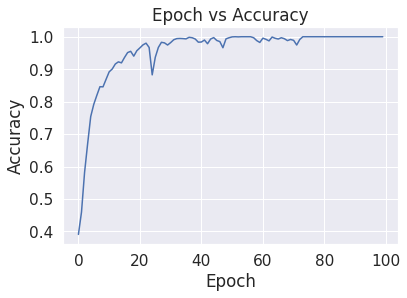

Test Accuracy 0.9473684430122375, Época:51

Test Accuracy 0.9473684430122375, Época:86

Test Accuracy 0.9438596367835999, Época:76

Test Accuracy 0.9438596367835999, Época:77

Test Accuracy 0.9438596367835999, Época:78


Train Accuracy 1.0, Época:52

Train Accuracy 1.0, Época:54

Train Accuracy 1.0, Época:55

Train Accuracy 1.0, Época:56

Train Accuracy 1.0, Época:57


Validation Accuracy 0.9260563254356384, Época:20

Validation Accuracy 0.9260563254356384, Época:75

Validation Accuracy 0.9260563254356384, Época:76

Validation Accuracy 0.9260563254356384, Época:77

Validation Accuracy 0.9260563254356384, Época:78



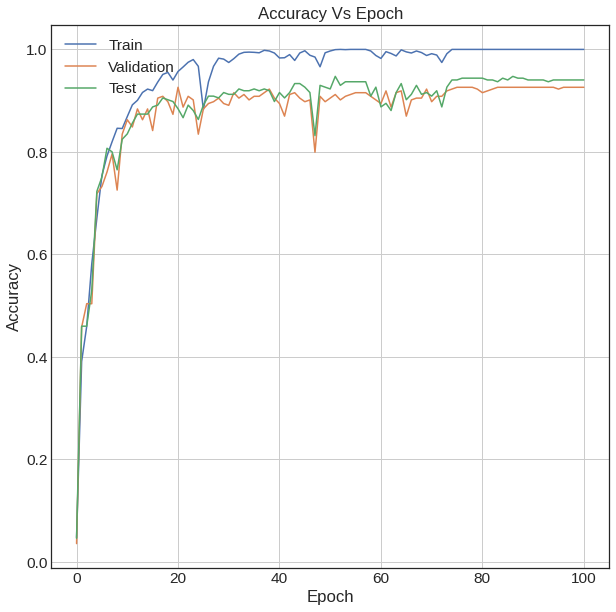

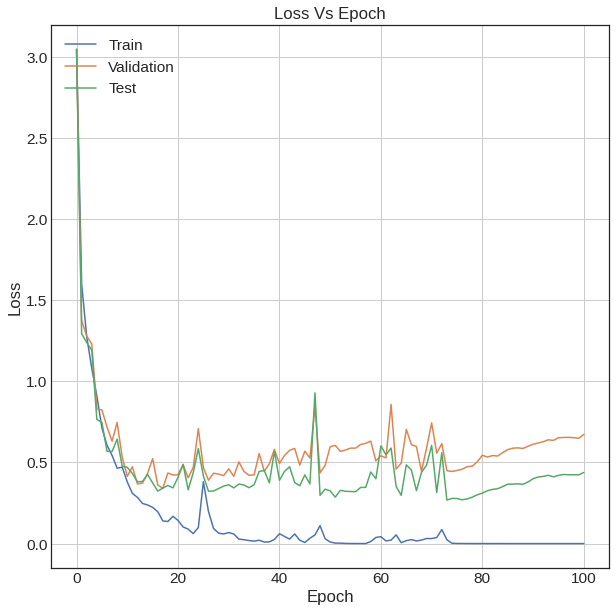

In [ ]:
# plot metrics
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


Baseline Error train: 0.00%
Baseline Error dev: 7.39%
Baseline Error test: 5.96%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       667
         3.0       1.00      1.00      1.00        24
         4.0       1.00      1.00      1.00        28
         9.0       1.00      1.00      1.00       372
        12.0       1.00      1.00      1.00       210
        13.0       1.00      1.00      1.00        55
        14.0       1.00      1.00      1.00        79
        16.0       1.00      1.00      1.00        19
        17.0       1.00      1.00      1.00       443
        18.0       1.00      1.00      1.00       133
        19.0       1.00      1.00      1.00        82
        20.0       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00    

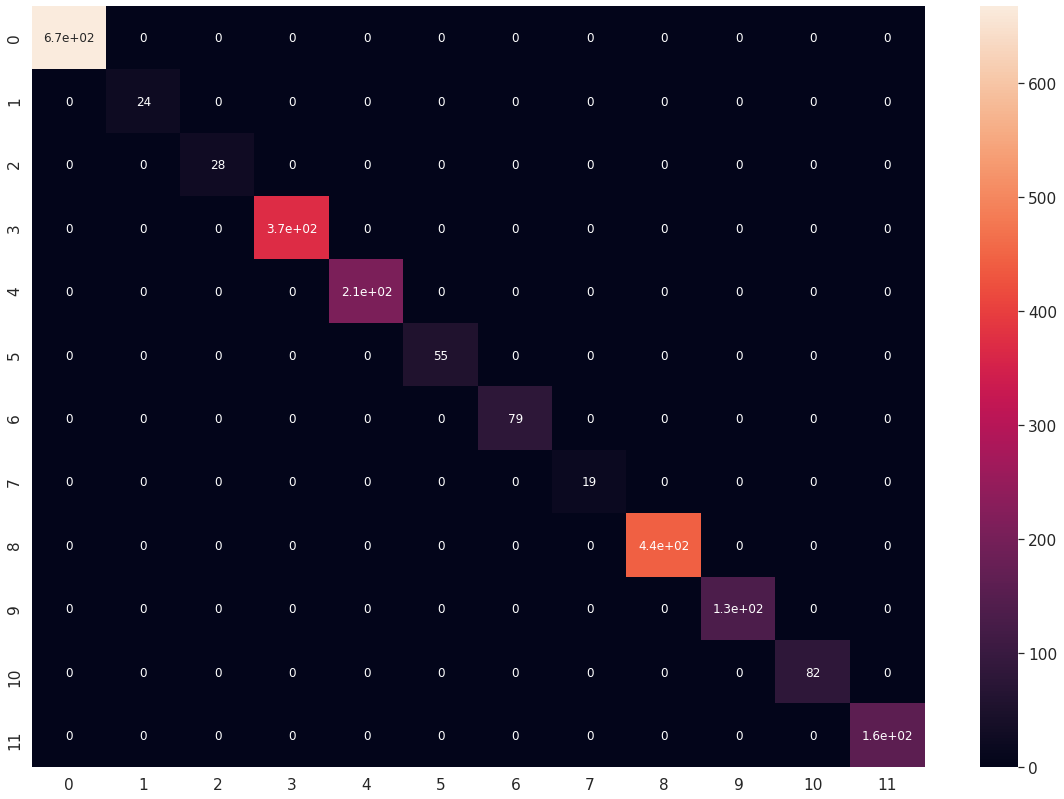

Accuracy: 0.926056338028169
F1 score: 0.9257241243639283
Recall: 0.926056338028169
Precision: 0.9319933441739338

 clasification report:
               precision    recall  f1-score   support

         1.0       0.97      0.99      0.98        88
         3.0       1.00      0.80      0.89         5
         4.0       0.78      1.00      0.88         7
         9.0       0.89      0.94      0.91        34
        12.0       0.97      0.82      0.89        34
        13.0       1.00      0.50      0.67         2
        14.0       0.73      1.00      0.85        11
        16.0       0.75      1.00      0.86         3
        17.0       0.98      0.94      0.96        48
        18.0       0.92      0.80      0.86        15
        19.0       0.89      0.94      0.91        17
        20.0       0.89      0.85      0.87        20

    accuracy                           0.93       284
   macro avg       0.90      0.88      0.88       284
weighted avg       0.93      0.93      0.93       

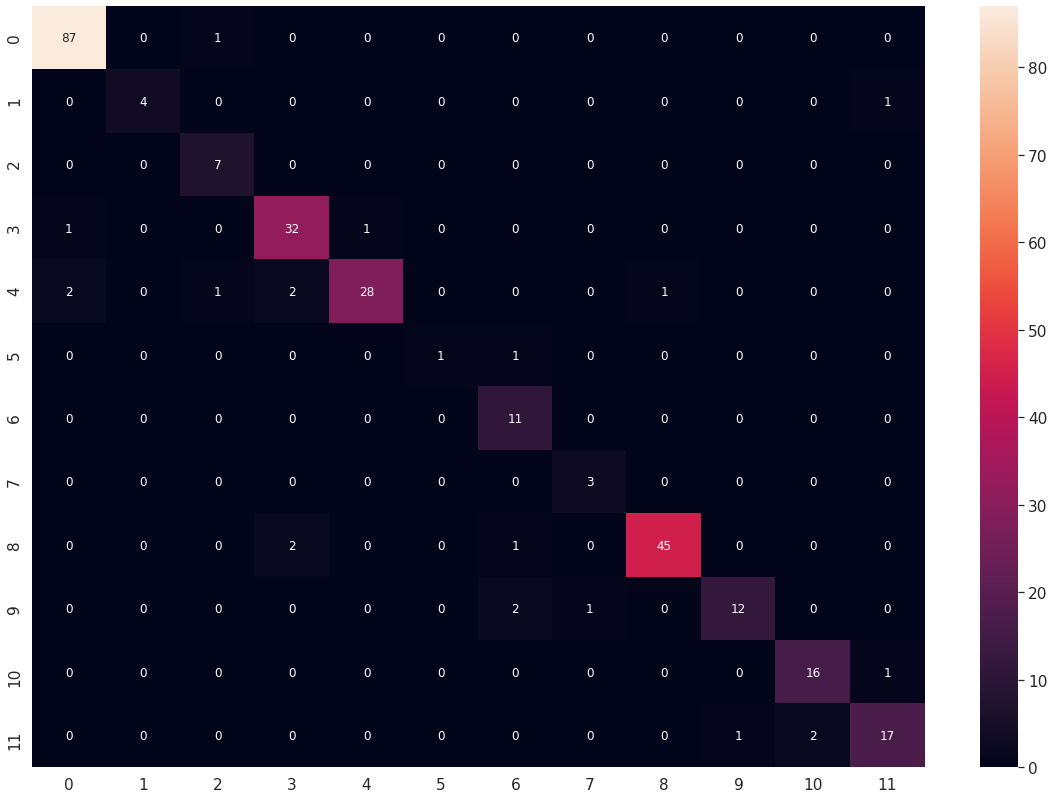

Accuracy: 0.9403508771929825
F1 score: 0.9419546811702858
Recall: 0.9403508771929825
Precision: 0.9477623032459224

 clasification report:
               precision    recall  f1-score   support

         1.0       0.97      0.96      0.97        79
         3.0       1.00      1.00      1.00         3
         4.0       0.50      1.00      0.67         1
         9.0       0.95      1.00      0.97        39
        12.0       1.00      0.89      0.94        37
        13.0       1.00      0.67      0.80         6
        14.0       0.83      0.91      0.87        11
        16.0       0.80      0.80      0.80         5
        17.0       0.98      0.98      0.98        60
        18.0       0.92      0.86      0.89        14
        19.0       0.55      0.75      0.63         8
        20.0       0.91      0.95      0.93        22

    accuracy                           0.94       285
   macro avg       0.87      0.90      0.87       285
weighted avg       0.95      0.94      0.94     

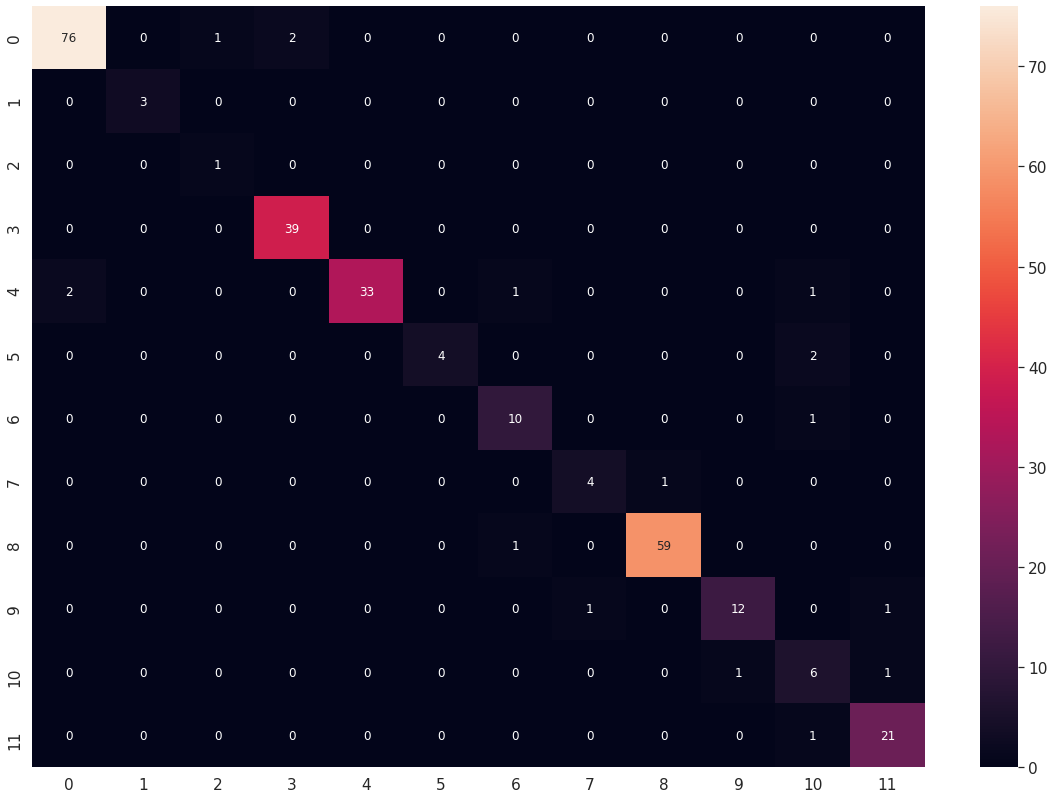

In [ ]:
scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])